In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from functools import partial
import jax
import jax.numpy as jnp
from numpyro.handlers import seed, condition
from sbi_lens.simulator import lensingLogNormal

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
'unset XLA_FLAGS'
import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


## Create fiducial and plot results

In [3]:
model = partial(lensingLogNormal,
                model_type='lognormal',
                with_noise=True)

# condition the model on a given set of parameters
fiducial_model = condition(model, {'omega_c': 0.2664, 
                                   'omega_b': 0.0492,
                                   'sigma_8': 0.831,
                                   'h_0': 0.6727,
                                   'n_s': 0.9645,
                                   'w_0': -1.0})

# sample a mass map
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(42))
m_data = sample_map_fiducial()

/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.9/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.9/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genmfd01/ulm7

In [4]:
theta_max=10
EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)
cmap = cmr.eclipse

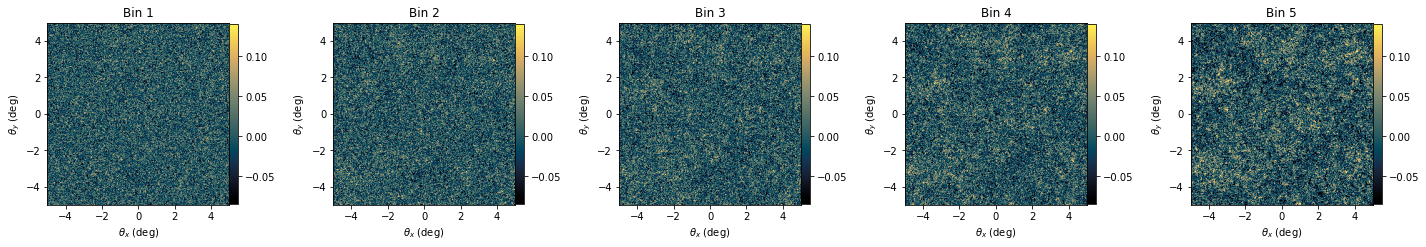

In [5]:

n_nz_bins=5
fig, ax = plt.subplots(1,n_nz_bins, figsize=(4 * n_nz_bins, 7))
for i in range(n_nz_bins):
    std_kmap = np.std(m_data[...,-1])
    ax[i].set_title('Bin %d'%(i+1))
    ax[i].set_xlabel(r'$\theta_x$ (deg)')
    ax[i].set_ylabel(r'$\theta_y$ (deg)')
    ax[i].imshow(m_data[...,i], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT)
    cb = fig.colorbar(ax[i].imshow(m_data[...,i], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
    cb.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

In [6]:
with open('/gpfsdswork/projects/rech/ykz/ulm75uc/sbi_lens/sbi_lens/data/m_data__256N_10ms_27gpa_026se.npy','wb') as f:
  save(f, m_data)

In [7]:
from sbi_lens.simulator.utils import get_reference_sample_posterior_full_field, get_reference_sample_posterior_power_spectrum, get_samples_and_scores

2023-04-14 01:19:06.669041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-2.7.0+py3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.8) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [8]:
samples_ps = get_reference_sample_posterior_power_spectrum(    
    run_mcmc=True,
    m_data=m_data,
    num_results=9_000,
     key=jax.random.PRNGKey(3))

/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.9/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.9/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genmfd01/ulm7

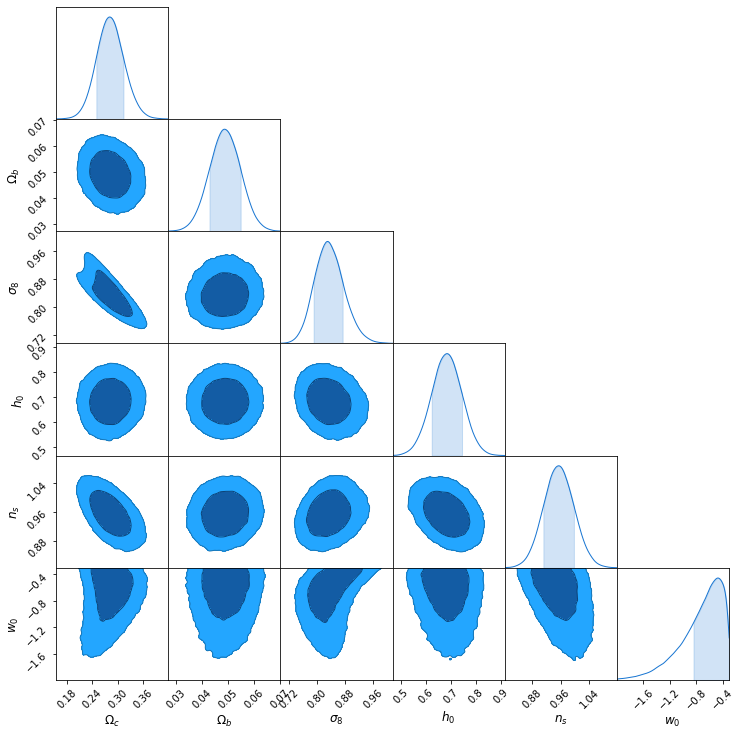

In [9]:
from chainconsumer import ChainConsumer
c = ChainConsumer()

c.add_chain([samples_ps[:,i] for i in range(6)], parameters= ['$\Omega_c$', '$\Omega_b$', '$\sigma_8$', '$h_0$', '$n_s$', '$w_0$'], name = 'Posterior')
fig = c.plotter.plot()
fig.set_size_inches(2 + fig.get_size_inches())

In [10]:
import pickle
with open("posterior_power_spectrum__"
                    "{}N_{}ms_{}gpa_{}se.npy".format(
                       256, 10, 27, 0.26), "wb") as fp:
    pickle.dump(samples_ps, fp)
